In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import SimpleITK as sitk

In [2]:
config_paths = {
    "luna16":"../../luna16/LUNA16/",
    "segment":"../../luna16/seg-lungs-LUNA16/",
    "annotations":"../../luna16/annotations.csv",
    "candidates":"../../luna16/candidates.csv",
    "slide_v1":"../center-coord-chunk",
    "slide_v2":"../center-coord-chunk-v2",
}

annotations = pd.read_csv(config_paths['annotations'])

In [3]:
annotations.head(2)

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708


In [4]:
# uitil
def get_uids(subset):
    files = os.listdir(config_paths["slide_v2"] + f"/subset{subset}-gt")

    uids = [f.split("_")[0] for f in files]

    return list(set(uids))

def num_annos_of_uid(uid):
    uids = annotations["seriesuid"].values

    return np.count_nonzero(uids == uid)

def num_annos_in_subset(subset):
    subset_uids = get_uids(subset)
    all_uids = annotations["seriesuid"].values

    result = 0

    for uid in subset_uids:
        result += np.count_nonzero(all_uids == uid)

    return result

def count_pixel(paths):
    """
    paths: path of slide annos of 1 image
    
    return total pixel and annos pixel mask.
    return list percentage per annos
    """
    total_pixel = 0
    annos_pixel = 0
    l_percentage = []

    for path in paths:
        image = np.load(path)

        total_pixel+= image.size
        annos_pixel += np.count_nonzero(image == 1)
        l_percentage.append(np.count_nonzero(image == 1)/(np.count_nonzero(image == 1) + image.size))

    return total_pixel, annos_pixel, l_percentage 

def get_index(image):
    """
    image: np.array of image

    return index contain value = 1 (mask value)
    """
    result = []

    for i in range(len(image)):
        if np.count_nonzero(image[i] == 1) > 0:
            result.append(i)

    return result

def read_sitk(path):
    ct_mhd = sitk.ReadImage(path)
    ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

    return ct_a

## Phần trăm của phổi so với ảnh CT (đọc folder segment)

[0. 3. 4. 5.]


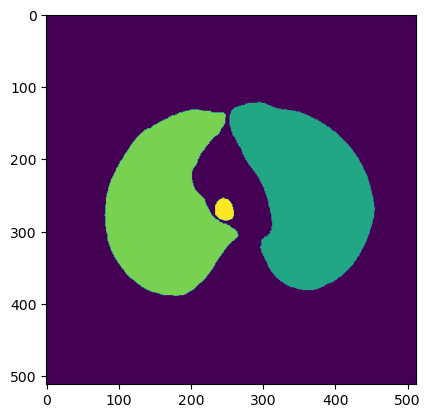

In [5]:
paths = glob.glob(config_paths['segment'] + "*.mhd")

test = read_sitk(paths[0])

print(np.unique(test))

plt.imshow(test[150])

# 3 phổi phải
# 4 phổi trái
# 5 ống phổi

In [6]:
pulmonary_pixels = 0
total_pixels = 0

for path in paths:
    image = read_sitk(path)

    total_pixels += image.size
    pulmonary_pixels += np.count_nonzero(image == 3) + np.count_nonzero(image == 4)

print(total_pixels)
print(pulmonary_pixels)
print((pulmonary_pixels)/ (total_pixels - pulmonary_pixels))

59565670400
8214377577
0.15996437724194587


## Phần trăm của nodule so với phổi

In [7]:
mask_paths = glob.glob("../../preprocess/subset*/*_gt.npy")

nodule_pixels = 0

for path in mask_paths:
    image = np.load(path)

    nodule_pixels += np.count_nonzero(image == 1)

print(nodule_pixels)
print(nodule_pixels/(pulmonary_pixels - nodule_pixels))

21511938
0.0026256915404053536


In [12]:
percentage_pulmonary_vs_total = round(((pulmonary_pixels)/ (- pulmonary_pixels + total_pixels))*100, 3)
percentage_nodule_vs_pulmonary = round((nodule_pixels/(- nodule_pixels + pulmonary_pixels))*100, 3)

print(percentage_pulmonary_vs_total)
print(percentage_nodule_vs_pulmonary)

15.996
0.263


## Vẽ biểu đồ hình tròn thể hiện %

Text(0.5, 1.0, 'Tỉ lệ phần trăm của khối U so với phổi')

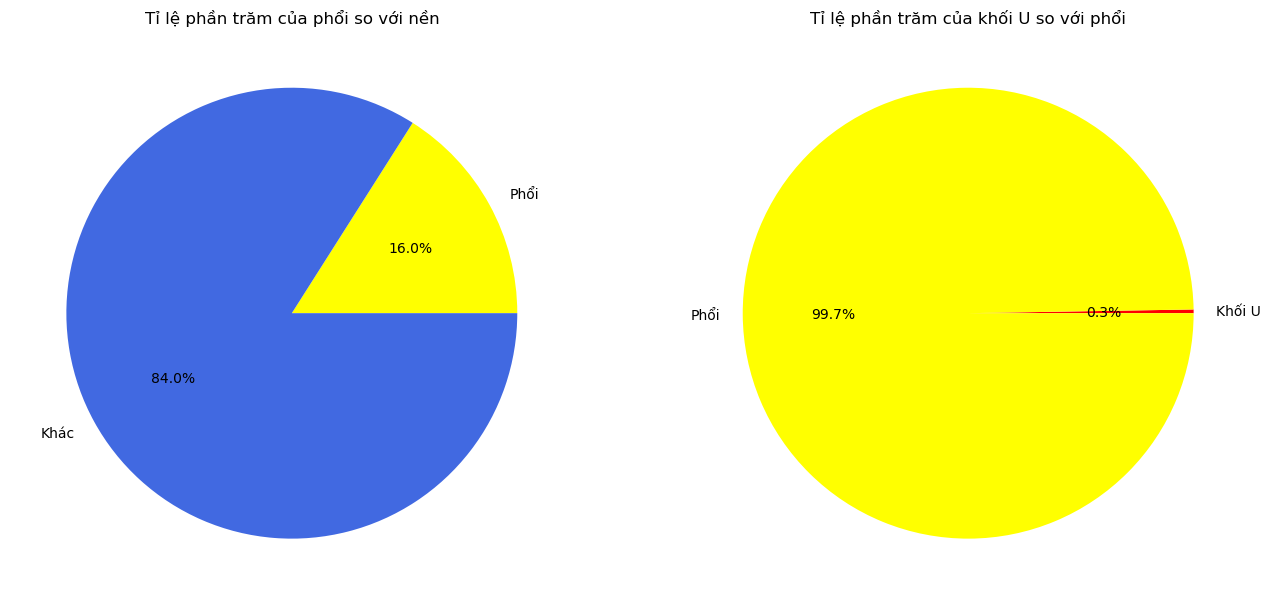

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 9))

axs[0].pie((percentage_pulmonary_vs_total, 100 - percentage_pulmonary_vs_total), labels=("Phổi", "Khác"), autopct='%1.1f%%', colors=['yellow', 'royalblue'])
axs[0].set_title("Tỉ lệ phần trăm của phổi so với nền")

axs[1].pie((percentage_nodule_vs_pulmonary, 100 - percentage_nodule_vs_pulmonary), labels=("Khối U", "Phổi"), autopct='%1.1f%%', colors=['red', 'yellow'])
axs[1].set_title("Tỉ lệ phần trăm của khối U so với phổi")

